## Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve


## Importa dados

In [2]:
# registra o diretório atual e muda para a pasta "dataset"
current_dir_orig = os.getcwd()
os.chdir(f"{current_dir_orig}/dataset")

In [3]:
depfed_dataset_df = pd.read_csv(r'./depfed_dataset.csv')

# change to original directory
os.chdir(current_dir_orig)

In [4]:
depfed_dataset_df.head()

,SQ_CANDIDATO,NM_CANDIDATO,NR_IDADE_DATA_POSSE,REELEICAO,ST_ELEITORAL,COR_RACA_AMARELA,COR_RACA_BRANCA,COR_RACA_INDIGENA,COR_RACA_NAO_INFORMADO,COR_RACA_PARDA,COR_RACA_PRETA,GENERO,FUNDO ESPECIAL,OUTROS RECURSOS,FUNDO PARTIDARIO,RAZAO_CAND_VAGA_UE,RAZAO_CANDPART_VAGAS_UE,PART_PRES_POS
0,70001650385,CELY LANGAMER MUNIZ,51,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,538615.0,0.0,0.0,25.750000,1.125000,6.0
1,170001618619,MARCOS BEZERRA CAMPELO,55,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,300000.0,17.320000,0.840000,6.0
2,220001605554,MARY TERESINHA BRAGANHOL,58,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,616525.0,243879.0,0.0,19.250000,1.125000,5.0
3,190001609675,FERNANDO DA SILVA FERNANDES,68,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,110800.0,0.0,0.0,22.891304,1.021739,6.0
4,130001612965,RAFAEL CANDIDO,32,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,150000.0,0.0,50000.0,19.962264,0.679245,6.0


### Separa dataset em treinamento e teste

In [5]:
# separa o dataset inicial em treinamento e teste, estratificado pelo resultado eleitoral
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(depfed_dataset_df, depfed_dataset_df["ST_ELEITORAL"]):
    
    strat_train_set = depfed_dataset_df.loc[train_index]
    strat_test_set = depfed_dataset_df.loc[test_index]

    
# strat_test_set["ST_ELEITORAL"].value_counts()/len(strat_test_set)
depfed_train_df =  strat_train_set.copy().reset_index(drop=True)
depfed_test_df =  strat_test_set.copy().reset_index(drop=True)

### Buscando correlações

In [6]:
# Matriz de correlações
corr_matrix = depfed_train_df.corr()

corr_matrix["ST_ELEITORAL"].sort_values(ascending=False)

ST_ELEITORAL               1.000000
REELEICAO                  0.564909
FUNDO ESPECIAL             0.519590
OUTROS RECURSOS            0.424164
FUNDO PARTIDARIO           0.167828
COR_RACA_BRANCA            0.108574
GENERO                     0.092426
RAZAO_CANDPART_VAGAS_UE    0.034827
NR_IDADE_DATA_POSSE        0.014954
COR_RACA_INDIGENA          0.014443
COR_RACA_AMARELA           0.011531
SQ_CANDIDATO              -0.002101
COR_RACA_NAO_INFORMADO    -0.011036
RAZAO_CAND_VAGA_UE        -0.019594
COR_RACA_PRETA            -0.063821
COR_RACA_PARDA            -0.069562
PART_PRES_POS             -0.191977
Name: ST_ELEITORAL, dtype: float64

In [7]:
# testando combinações de atributos
depfed_train_df["RECEITA_TOTAL"] = depfed_train_df["FUNDO ESPECIAL"] + depfed_train_df["OUTROS RECURSOS"] + depfed_train_df["FUNDO PARTIDARIO"]

corr_matrix = depfed_train_df.corr()

corr_matrix["ST_ELEITORAL"].sort_values(ascending=False)

ST_ELEITORAL               1.000000
RECEITA_TOTAL              0.576699
REELEICAO                  0.564909
FUNDO ESPECIAL             0.519590
OUTROS RECURSOS            0.424164
FUNDO PARTIDARIO           0.167828
COR_RACA_BRANCA            0.108574
GENERO                     0.092426
RAZAO_CANDPART_VAGAS_UE    0.034827
NR_IDADE_DATA_POSSE        0.014954
COR_RACA_INDIGENA          0.014443
COR_RACA_AMARELA           0.011531
SQ_CANDIDATO              -0.002101
COR_RACA_NAO_INFORMADO    -0.011036
RAZAO_CAND_VAGA_UE        -0.019594
COR_RACA_PRETA            -0.063821
COR_RACA_PARDA            -0.069562
PART_PRES_POS             -0.191977
Name: ST_ELEITORAL, dtype: float64

<AxesSubplot:xlabel='RECEITA_TOTAL', ylabel='ST_ELEITORAL'>

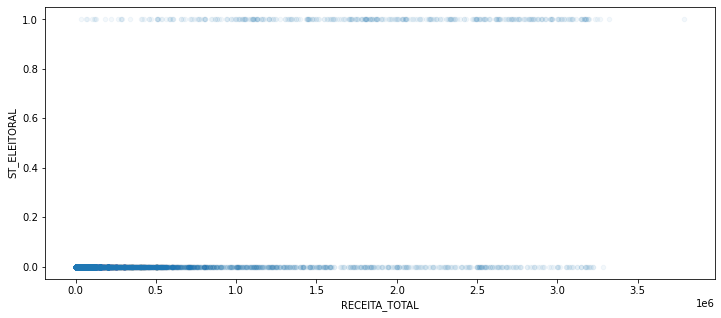

In [8]:
depfed_train_df.plot(kind="scatter", x="RECEITA_TOTAL", y="ST_ELEITORAL", alpha=0.05, figsize=(12,5))

In [9]:
# guarda os targets em st_eleitoral
y_train = depfed_train_df["ST_ELEITORAL"].values

depfed_dataset = depfed_train_df.drop(['SQ_CANDIDATO','NM_CANDIDATO','ST_ELEITORAL'], axis=1, inplace=False)
depfed_dataset.head()

,NR_IDADE_DATA_POSSE,REELEICAO,COR_RACA_AMARELA,COR_RACA_BRANCA,COR_RACA_INDIGENA,COR_RACA_NAO_INFORMADO,COR_RACA_PARDA,COR_RACA_PRETA,GENERO,FUNDO ESPECIAL,OUTROS RECURSOS,FUNDO PARTIDARIO,RAZAO_CAND_VAGA_UE,RAZAO_CANDPART_VAGAS_UE,PART_PRES_POS,RECEITA_TOTAL
0,65,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,10256.41,30750.00,0.0,20.828571,0.700000,6.0,41006.41
1,60,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,40000.00,0.00,0.0,22.891304,0.826087,6.0,40000.00
2,43,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30000.00,0.00,6060.6,19.962264,1.018868,5.0,36060.60
3,42,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10000.00,0.00,0.0,17.769231,0.410256,6.0,10000.00
4,52,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,325.53,150000.0,18.875000,1.125000,2.0,150325.53


### Scaling

In [10]:
# pipeline de transformação. As colunas do dataset saem trocadas de acodo com o ColumnTransformer

num_columns = ['NR_IDADE_DATA_POSSE',
               'FUNDO ESPECIAL',
               'OUTROS RECURSOS',
               'FUNDO PARTIDARIO',
               'RAZAO_CAND_VAGA_UE',
               'RAZAO_CANDPART_VAGAS_UE',
               'PART_PRES_POS',
               'RECEITA_TOTAL'
              ]

full_pipeline = ColumnTransformer([("num", StandardScaler(), num_columns)], remainder='passthrough')

X_train_prep = full_pipeline.fit_transform(depfed_dataset)

# full_pipeline.get_feature_names_out(depfed_dataset.columns)

### 1° Classificador - SGD Classifier

In [11]:
# treina SGDClassifier()
sgd_clf = SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.01, l1_ratio=0.6, random_state=42)
sgd_clf.fit(X_train_prep, y_train)

sgd_clf.predict(X_train_prep[:10,:])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Desempenho

Como estamos manipulando **dados assimétricos**, uma vez que a proporção de candidatos eleitos é bem menor do que não eleitos, é normal a acurácia ser bem alta. Para avaliarmos melhor as previsões, usaremos métodos mais robustos.

In [12]:
# proporção de eleitos (1) e não eleitos (0) no conjunto de treinamento
depfed_train_df["ST_ELEITORAL"].value_counts()/len(depfed_train_df)

0.0    0.948596
1.0    0.051404
Name: ST_ELEITORAL, dtype: float64

In [13]:
# computa a acurácia em cada fold
cross_val_score(sgd_clf, X_train_prep, y_train, cv=None, scoring="accuracy")

array([0.95864662, 0.95673981, 0.95799373, 0.9661442 , 0.95673981])

In [14]:
# faz a previsão para ca instancia em cada fold
y_train_pred = cross_val_predict(sgd_clf, X_train_prep, y_train, cv=None)

# matriz de confusão
conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Matriz de confusão: \n", conf_matrix)

# calcula precion e recall das previsões
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)

# F1 score
f1_scr = f1_score(y_train, y_train_pred)

print("\nPrecision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_scr)


Matriz de confusão: 
 [[7470   96]
 [ 229  181]]

Precision:  0.6534296028880866
Recall:  0.44146341463414634
F1 score:  0.5269286754002912


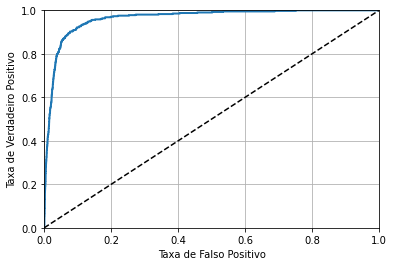

In [15]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.grid()
    plt.ylim([0, 1.0])
    plt.xlim([0, 1.0])
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.xlabel('Taxa de Falso Positivo')

# retorna o score de cada instância de treinamento
y_scores_sgd = cross_val_predict(sgd_clf, X_train_prep, y_train, cv=None, method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train, y_scores_sgd)

# Plot
plot_roc_curve(fpr, tpr)
plt.show()



### 2° Classificador - Random Forest

In [16]:
# treina RandomForestClassifier()
forest_clf = RandomForestClassifier(n_estimators=300, min_samples_leaf=3, bootstrap=True, random_state=42)
forest_clf.fit(X_train_prep, y_train)

forest_clf.predict(X_train_prep[:10,:])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
# faz a previsão para ca instancia em cada fold
y_train_pred = cross_val_predict(forest_clf, X_train_prep, y_train, cv=None)

# matriz de confusão
conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Matriz de confusão: \n", conf_matrix)

# calcula precion e recall das previsões
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)

# F1 score
f1_scr = f1_score(y_train, y_train_pred)

print("\nPrecision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_scr)


Matriz de confusão: 
 [[7459  107]
 [ 209  201]]

Precision:  0.6525974025974026
Recall:  0.4902439024390244
F1 score:  0.5598885793871866


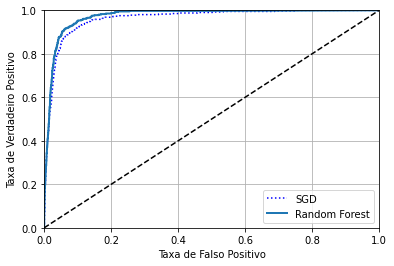

In [18]:
# retorna a probabilidade de cada instância de treinamento
y_probas_forest = cross_val_predict(forest_clf, X_train_prep, y_train, cv=None, method="predict_proba")

# seleciona os scores positivos
y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

# Plot
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc="lower right")
plt.show()

### 3° Classificador - Logistic Regression

In [19]:
# treina LogisticRegressionCV()
logreg_clf = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42, max_iter=10000)
logreg_clf.fit(X_train_prep, y_train)

logreg_clf.predict(X_train_prep[:10,:])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

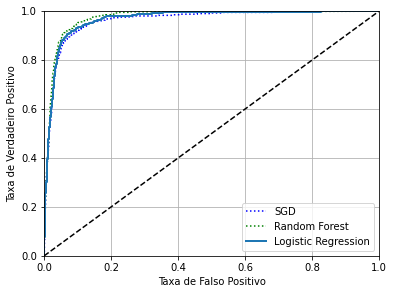

In [20]:
# retorna a probabilidade de cada instância de treinamento
y_probas_logreg = cross_val_predict(logreg_clf, X_train_prep, y_train, cv=None, method="predict_proba")

# seleciona os scores positivos
y_scores_logreg = y_probas_logreg[:, 1]

fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_train, y_scores_logreg)

# Plot
plt.figure(figsize=(6,4.5))
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, "g:", label="Random Forest")
plot_roc_curve(fpr_logreg, tpr_logreg, label="Logistic Regression")
plt.legend(loc="lower right")
plt.show()

### 4° Classificador - SVM

In [21]:
# treina SVC()
svc_clf = SVC(C=0.1, kernel='rbf', degree=3, gamma='scale', tol=0.0001, random_state=42)
svc_clf.fit(X_train_prep, y_train)

svc_clf.predict(X_train_prep[:10,:])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

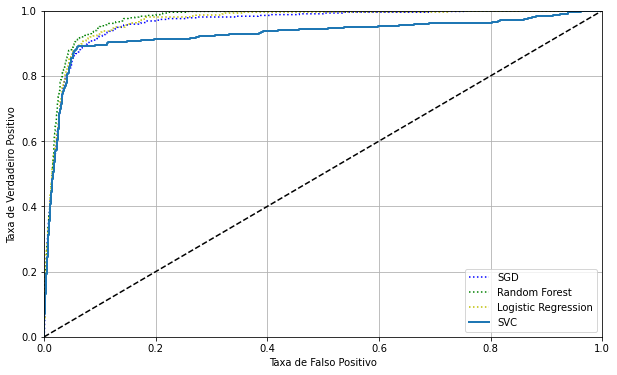

In [22]:
# retorna o score de cada instância de treinamento
y_scores_svc = cross_val_predict(svc_clf, X_train_prep, y_train, cv=None, method="decision_function")

fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_train, y_scores_svc)

# Plot
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, "g:", label="Random Forest")
plt.plot(fpr_logreg, tpr_logreg, "y:", label="Logistic Regression")
plot_roc_curve(fpr_svc, tpr_svc, label="SVC")
plt.legend(loc="lower right")
plt.show()

### 1° Optimização - SGD Classifier

In [23]:
param_grid = [{'penalty': ['l2', 'l1', 'elasticnet'],
               'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10],
               'l1_ratio': np.linspace(0.0, 1.0, num=6).tolist()               
              }]

sgd_clf = SGDClassifier(loss='hinge', max_iter=10000, tol=0.0001, random_state=42, learning_rate='optimal')

grid_search = GridSearchCV(sgd_clf, param_grid, scoring='roc_auc', cv=None)

grid_search.fit(X_train_prep, y_train)


GridSearchCV(estimator=SGDClassifier(max_iter=10000, random_state=42,
                                     tol=0.0001),
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10],
                          'l1_ratio': [0.0, 0.2, 0.4, 0.6000000000000001, 0.8,
                                       1.0],
                          'penalty': ['l2', 'l1', 'elasticnet']}],
             scoring='roc_auc')

In [24]:
grid_search.best_params_

{'alpha': 0.01, 'l1_ratio': 0.6000000000000001, 'penalty': 'elasticnet'}

In [25]:
grid_search.best_score_

0.9684449849965867

### 2° Optimização - Random Forest

In [26]:
param_grid = [{'n_estimators': [300],
               'criterion': ['gini'],
               'min_samples_split': [2],
               'min_samples_leaf': [3],
               'bootstrap': [True],
               
              }]

forest_clf = RandomForestClassifier(random_state=42)

grid_search_forest = GridSearchCV(forest_clf, param_grid, scoring='roc_auc', cv=None)

grid_search_forest.fit(X_train_prep, y_train)


GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'bootstrap': [True], 'criterion': ['gini'],
                          'min_samples_leaf': [3], 'min_samples_split': [2],
                          'n_estimators': [300]}],
             scoring='roc_auc')

In [27]:
grid_search_forest.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 300}

In [28]:
grid_search_forest.best_score_

0.9739917461156153

### 3° Optimização - Logistic regression

In [29]:
param_grid = [{'penalty': ['elasticnet'],
               'C': np.logspace(-4, 4, num=9).tolist(),
               'l1_ratio': np.linspace(0.0, 1.0, num=6).tolist()
              }]

logreg_clf = LogisticRegression(tol=0.0001, random_state=42, solver='saga', max_iter=10000)

grid_search_logreg = GridSearchCV(logreg_clf, param_grid, scoring='roc_auc', cv=None)

grid_search_logreg.fit(X_train_prep, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, random_state=42,
                                          solver='saga'),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                1000.0, 10000.0],
                          'l1_ratio': [0.0, 0.2, 0.4, 0.6000000000000001, 0.8,
                                       1.0],
                          'penalty': ['elasticnet']}],
             scoring='roc_auc')

In [30]:
grid_search_logreg.best_params_

{'C': 0.1, 'l1_ratio': 1.0, 'penalty': 'elasticnet'}

In [31]:
grid_search_logreg.best_score_

0.9676494673085007

### 4° Optimização - SVC

In [ ]:
param_grid = [{'kernel': ['linear', 'poly', 'rbf'],
               'C': np.logspace(-4, 4, num=9).tolist(),
               'degree': [1],
               'gamma': ['scale','auto']
              }]

svc_clf = SVC(tol=0.0001, random_state=42)

grid_search_svc = GridSearchCV(svc_clf, param_grid, scoring='roc_auc', cv=None)

grid_search_svc.fit(X_train_prep, y_train)

In [ ]:
grid_search_svc.best_params_

In [ ]:
grid_search_svc.best_score_